# Capstone_project
# Scenario quantification

## Introduction
The purpose of this project is to develop a statistical model to predict economic losses associated with financial risks, specifically credit, market, or operational risks. Financial institutions constantly face these risks, and their ability to measure and manage potential losses is crucial for ensuring financial stability.

**Problem Statement**
The main problem addressed in this project is the accurate prediction of economic losses due to financial risk events. Identifying the factors that influence these losses and developing a predictive model will enable institutions to make informed decisions to mitigate these risks.

**Significance**
Managing financial risks is essential for institutions operating in highly volatile markets. By developing an efficient predictive model, potential losses can be estimated, allowing for proactive mitigation strategies. This not only improves financial stability but also optimizes capital allocation, ensuring institutions comply with regulatory requirements and maintain solvency.

Let's load the needed libraries.

# Libraries

In [ ]:
# from dateutil.relativedelta import relativedelta
!pip install -U distfit # https://erdogant.github.io/distfit/pages/html/index.html
from distfit import distfit
# !pip install fitter
# from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_excel, read_csv
pd.options.display.max_columns = None
import random
# import re
from scipy import stats
import seaborn as sns
from sqlalchemy import create_engine
import sys
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# import gspread
# from google.auth import default
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)
# import requests
# from gspread_dataframe import set_with_dataframe
# from google.colab import files
# from datetime import datetime, timedelta
# from openpyxl import Workbook, load_workbook
# from openpyxl.styles import Font
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaFileUpload

# Load data

Dataset Overview

The dataset used in this project is a CSV file containing two key columns: date and loss. These columns provide the minimum necessary information to operate the economic model for predicting financial losses.

Source: The dataset is provided alongside the project code as an anonymized sample dataset. It functions as an illustrative example for building the economic model.

Format: CSV file with two columns:

fecha: The date of the recorded financial event.

losses: The amount of financial loss associated with the event on the given date.

In [ ]:
def str_time_prop(start, end, time_format, prop):
  '''
  Get a time at a proportion of a range of two formatted times.

  start and end should be strings specifying times formatted in the
  given format (strftime-style), giving an interval [start, end].
  prop specifies how a proportion of the interval to be taken after
  start.  The returned time will be in the specified format.
  '''

  stime = time.mktime(time.strptime(start, time_format))
  etime = time.mktime(time.strptime(end, time_format))

  ptime = stime + prop * (etime - stime)

  return time.strftime(time_format, time.localtime(ptime))

def random_date(start, end, prop):
  return str_time_prop(start, end, '%d/%m/%Y', prop)

The above functions helps us to generate random dates between two given dates, and the real data has lognorm distribution with parameters `s=1`, `loc=0.3`, and `scale=50`. We will create 162397 sampled data.

In [ ]:
fechas = [random_date('1/1/2023', '31/12/2023', random.random()) for i in range(162397)]
losses = stats.lognorm.rvs(s=1, loc=0.3, scale=50, size=162397, random_state=123)
df = pd.DataFrame({'fecha': fechas, 'losses': losses})
df.to_csv('losses_1.csv', index=False)

# EDA

**Variable Significance**
* fecha: This variable represents the time dimension of the financial loss data. It is essential for identifying trends or patterns in the occurrence of financial loss events over time, which could be important for making temporal predictions.

* losses: The loss variable quantifies the economic impact of each financial event. It is the primary dependent variable that the model aims to predict. Accurately modeling this variable allows financial institutions to anticipate potential losses and implement mitigation strategies accordingly.

**Importance to the Problem**
Given that financial institutions need to predict and manage risk, the combination of date and loss data provides a foundation for constructing a time-series model or other relevant statistical models. By analyzing historical loss data, the model can forecast future losses and help institutions prepare for potential financial downturns.

In [ ]:
df['losses'].describe(percentiles=[x/100 for x in range(10, 91, 10)])

count    162397.000000
mean         82.746024
std         107.886701
min           0.909625
10%          14.259113
20%          21.925558
30%          29.959801
40%          39.159719
50%          50.370651
60%          64.773522
70%          85.072108
80%         116.424519
90%         180.261172
max        3682.794655
Name: losses, dtype: float64

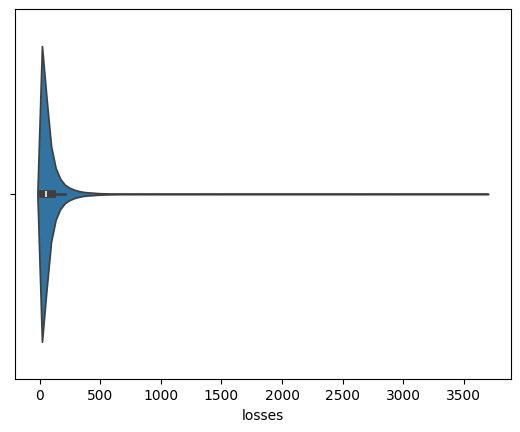

In [ ]:
sns.violinplot(x=df['losses']);

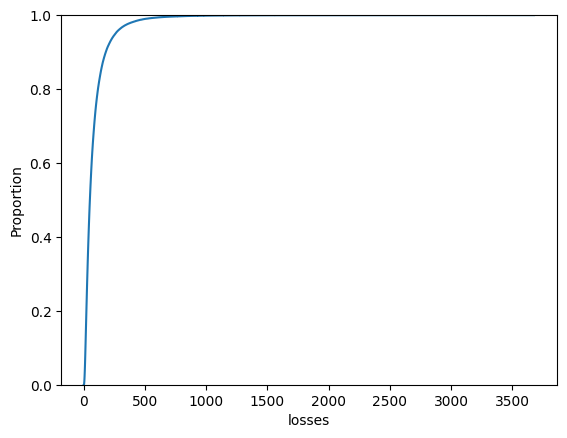

In [ ]:
sns.ecdfplot(x=df['losses']);

In [ ]:
q99_9 = np.quantile(df['losses'], 0.999)
q99_9

1106.7379141245835

In [ ]:
periodo = 'M'

In [ ]:
df['periodo'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y').dt.to_period(periodo)

[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


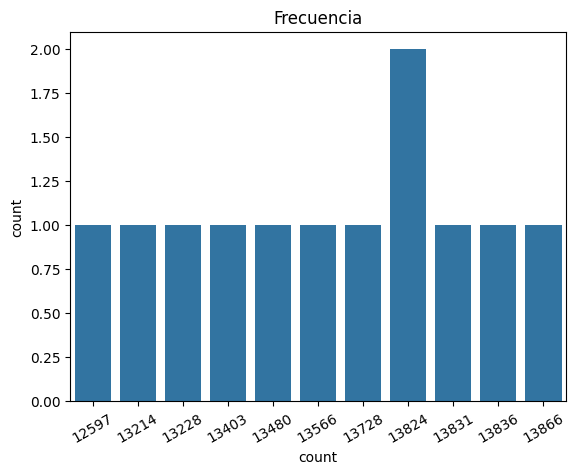

In [ ]:
sns.countplot(x=df['periodo'].value_counts());
plt.title('Frecuencia');
plt.xticks(rotation=30);

# Model

## Approach and Methodology
To address the problem of predicting economic losses due to financial risks, we employ an Aggregate Loss Distribution Approach. This approach involves combining the frequency and severity distributions of financial losses to model the total loss distribution effectively. The methodology includes the following steps:

**1. Frequency Distribution:**

This represents the number of financial loss events occurring over a specific period. It can be modeled using various statistical distributions, such as Poisson or Negative Binomial distributions, depending on the nature of the data.

**2. Severity Distribution:**

This represents the magnitude of losses associated with each event. Common distributions used for modeling severity include the Exponential, Gamma, or Pareto distributions, depending on the characteristics of the loss data.

**3. Convolution of Distributions:**

The total loss distribution is obtained by convolving the frequency and severity distributions. Mathematically, if $F(x)$ represents the cumulative distribution function (CDF) of the frequency distribution and $S(x)$ represents the CDF of the severity distribution, the convolution can be expressed as:

$$L(x) = \int_{0}^{x} f(x - y) \cdot\ s(y) dy$$

where $f(x)$ is the probability density function (PDF) of the frequency distribution and s(x) is the PDF of the severity distribution. This integral calculates the total loss distribution by combining the frequency and severity data.


## Frequency

In [ ]:
frequencies = df['periodo'].value_counts().sort_index()

In [ ]:
frequency_model = distfit(method='discrete')
frequency_model.fit_transform(frequencies, verbose=1)
mu = frequencies.mean()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> Fit using binomial distribution.
[distfit] >DEBUG> [distfit] >Initial estimate: n=1, p=1.35e+04
[distfit] >DEBUG> [binomial] [RSS=0.597] Trying n=1 -> p=0.5, (initial=1)
[distfit] >DEBUG> [binomial] [RSS=0.472] Trying n=2 -> p=0.5, (initial=1)
[distfit] >INFO> [distfit] >[binomial] [RSS=0.472] [n=2] [p=0.500028] [chi^2=3.41e-05]
[distfit] >INFO> Compute confidence intervals [discrete]


In [ ]:
frequency_model.model

{'name': 'binom',
 'model': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f705b645150>,
 'params': (2, 0.500027968557964),
 'score': 0.4722222230044626,
 'chi2r': 3.4058580815323664e-05,
 'n': 2,
 'p': 0.500027968557964,
 'CII_min_alpha': 0.0,
 'CII_max_alpha': 2.0}

## Severity

In [ ]:
severity_model = distfit(alpha=0.05, bins=50, stats='ks')
severity_model.fit_transform(df['losses'], verbose=1)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (82.74602392210393, 107.88636857998125)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 8.58113] [loc=82.746 scale=107.886]
[distfit] >DEBUG> (0.9096250982120107, 81.83639882389193)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 5.80095] [loc=0.910 scale=81.836]
[distfit] >DEBUG> (6.803931979946593, -470.7896618465304, 471.69928694474237)
[distfit] >INFO> [pareto    ] [0.20 sec] [ks: 1.66338] [loc=-470.790 scale=471.699]
[distfit] >DEBUG> (0.791383557958335, 40.34912218958968, 48.531643389307035)
[distfit] >INFO> [dweibull  ] [4.99 sec] [ks: 5.31808] [loc=40.349 scale=48.532]
[distfit] >DEBUG> (1.508109581624651, 46.47432980540823, 31.879387186017247)
[distfit] >INFO> [t         ] [19.4 sec] [ks: 3.23489] [loc=46.474 scale=31.879]
[distfit] >DEBUG> (-0.5794101169812028, 35.90212231039201, 31.217073035355664)
[distfit] >INFO> [genextreme] [8.85 sec] [ks: 4.42012] [loc=35.902 scale=31.217]
[distfit] >DEBUG> (1.119330904452261

{'model': {'name': 'lognorm',
  'score': 0.7481509319599611,
  'loc': 0.304003497594704,
  'scale': 50.085702479507795,
  'arg': (0.9981201510636069,),
  'params': (0.9981201510636069, 0.304003497594704, 50.085702479507795),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f705b647160>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': 10.002530679863339,
  'CII_max_alpha': 258.9595236318361},
 'summary':           name      score           loc        scale  \
 0      lognorm   0.748151      0.304003    50.085702   
 1       pareto   1.663383   -470.789662   471.699287   
 2            t   3.234885      46.47433    31.879387   
 3   genextreme   4.420122     35.902122    31.217073   
 4     dweibull   5.318078     40.349122    48.531643   
 5        expon   5.800951      0.909625    81.836399   
 6        gamma   6.307231      0.909362    72.950908   
 7         beta   6.307231      0.906553   56592.4053   
 8         nor

In [ ]:
# model.plot(verbose=1);
severity_model.summary

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,lognorm,0.748151,0.304003,50.085702,"(0.9981201510636069,)","(0.9981201510636069, 0.304003497594704, 50.085...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,pareto,1.663383,-470.789662,471.699287,"(6.803931979946593,)","(6.803931979946593, -470.7896618465304, 471.69...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,t,3.234885,46.47433,31.879387,"(1.508109581624651,)","(1.508109581624651, 46.47432980540823, 31.8793...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#377eb8
3,genextreme,4.420122,35.902122,31.217073,"(-0.5794101169812028,)","(-0.5794101169812028, 35.90212231039201, 31.21...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#4daf4a
4,dweibull,5.318078,40.349122,48.531643,"(0.791383557958335,)","(0.791383557958335, 40.34912218958968, 48.5316...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#984ea3
5,expon,5.800951,0.909625,81.836399,(),"(0.9096250982120107, 81.83639882389193)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ff7f00
6,gamma,6.307231,0.909362,72.950908,"(1.1193309044522617,)","(1.1193309044522617, 0.9093617082935235, 72.95...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ffff33
7,beta,6.307231,0.906553,56592.4053,"(1.1163499032464417, 773.6568868555287)","(1.1163499032464417, 773.6568868555287, 0.9065...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#a65628
8,norm,8.581128,82.746024,107.886369,(),"(82.74602392210393, 107.88636857998125)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#f781bf
9,loggamma,8.581128,-41297.972751,5419.450365,"(2070.938720315731,)","(2070.938720315731, -41297.97275058342, 5419.4...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


In [ ]:
severity_model.model

{'name': 'lognorm',
 'score': 0.7481509319599611,
 'loc': 0.304003497594704,
 'scale': 50.085702479507795,
 'arg': (0.9981201510636069,),
 'params': (0.9981201510636069, 0.304003497594704, 50.085702479507795),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f705b647160>,
 'bootstrap_score': 0,
 'bootstrap_pass': None,
 'color': '#e41a1c',
 'CII_min_alpha': 10.002530679863339,
 'CII_max_alpha': 258.9595236318361}

In [ ]:
import inspect
# sig = inspect.signature(stats.lognorm._pdf)

severity_distribution = severity_model.model['name']
sig = eval(f'inspect.signature(stats.{severity_distribution}._pdf)')
arg_names = [p for p in sig.parameters.keys() if p not in ['self', 'x']]
arg_values = [x for x in severity_model.model['arg']]
parameters_str = ', '.join([f'{v}' for v in arg_values])
loc = severity_model.model['loc']
scale = severity_model.model['scale']

eval('stats.{}.rvs({}, loc={}, scale={}, size=100000)'.format(severity_distribution, parameters_str, loc, scale))

array([21.61652315, 15.33117746, 25.88552486, ..., 58.3151072 ,
       54.58469472, 18.09429205])

In [ ]:
parameters_dict = {}
[parameters_dict.update({arg_names[0]: x}) for i, x in enumerate(severity_model.model['arg'])]
parameters_dict.update({'loc': loc})
parameters_dict.update({'scale': scale})

In [ ]:
res = stats.goodness_of_fit(
  dist=eval(f"stats.{severity_model.model['name']}"),
  data=df['losses'], statistic='ks',
  fit_params=parameters_dict,
  n_mc_samples=1000,
  random_state=17
)
pvalue = res.pvalue

0.5614385614385614

# Monte Carlo

**4. Monte Carlo Simulations:**

Monte Carlo simulations are used to estimate the aggregate loss distribution by generating random samples based on the frequency and severity distributions. The process involves the following steps:

1. Simulate Number of Events: For each simulation run, draw a random number from the frequency distribution to determine the number of loss events.
2. Simulate Loss Amounts: For each event, draw random loss amounts from the severity distribution.
3. Aggregate Loss Calculation: Sum the loss amounts for each simulation run to compute the total loss.
   
Mathematically, if $N$ represents the number of simulations, $E_{i}$ is the number of events in the $i-th$ simulation, and $\lbrace L_{i, j} \rbrace_{j=1}^{E_i}$ are the simulated loss amounts for the $i-th$ simulation, the total loss for the $i-th$ simulation can be expressed as:

$$T_i = \sum_{j=1}^{E_i} L_{i, j}.$$

The aggregate loss distribution is then approximated by the empirical distribution of $\lbrace T_i \rbrace_{i=1}^{N}$, which represents the total losses over all simulations.

$$\hat{L}(x) = \frac{1}{N} \sum_{i=1}^{N} \mathbb{I}(T_{i} \leq x)$$

where $\mathbb{I}(T_{i} \leq x)$ is an indicator function that equals $1$ if $T_i$ is less than or equal to $x$ and $0$ otherwise. This approximation helps in estimating the probability of various levels of aggregate losses.

In [ ]:
print('Poisson parameter:', mu)
print('Severity model:', severity_distribution, '\n\tparameters:', parameters_dict)

Poisson parameter: 13533.083333333334
Severity model: lognorm 
	parameters: {'s': 0.9981201510636069, 'loc': 0.304003497594704, 'scale': 50.085702479507795}


In [ ]:
simulations = []

for i in range(100000):
  frequency = int(stats.poisson.ppf(q=stats.uniform.rvs(size=1), mu=mu))
  simulations.append(np.sum(eval('stats.{}.rvs({}, loc={}, scale={}, size={})'.format(severity_distribution, parameters_str, loc, scale, frequency))))

In [ ]:
print(pd.Series(simulations).describe(percentiles=[x/100 for x in range(10, 91, 10)] + [0.95, 0.999]).to_string())

count    1.000000e+05
mean     1.119547e+06
std      1.582607e+04
min      1.047099e+06
10%      1.099464e+06
20%      1.106259e+06
30%      1.111168e+06
40%      1.115480e+06
50%      1.119451e+06
60%      1.123387e+06
70%      1.127749e+06
80%      1.132794e+06
90%      1.139919e+06
95%      1.145867e+06
99.9%    1.169090e+06
max      1.184665e+06


In [ ]:
df.groupby('periodo')['losses'].sum()

periodo
2023-01    1.144451e+06
2023-02    1.023640e+06
2023-03    1.173834e+06
2023-04    1.095386e+06
2023-05    1.161068e+06
2023-06    1.103890e+06
2023-07    1.140277e+06
2023-08    1.143120e+06
2023-09    1.090087e+06
2023-10    1.133924e+06
2023-11    1.115213e+06
2023-12    1.112816e+06
Freq: M, Name: losses, dtype: float64

# Recap

**Rationale Behind the Approach**

The Aggregate Loss Distribution Approach effectively models complex loss scenarios by integrating different aspects of loss events. Convolution provides a way to combine frequency and severity data into a single distribution, and Monte Carlo simulations offer a practical method to approximate this distribution, especially when analytical solutions are complex or infeasible.

## Proposed Solution Overview
The proposed solution involves developing a comprehensive model to predict economic losses due to financial risks using the Aggregate Loss Distribution Approach. The overall architecture of the solution includes several key components that work together to address the problem and achieve accurate predictions.

**Overall Architecture and Workflow**

**Data Preparation**
* Data Import and Cleaning: Load the dataset from the CSV file, which includes the date and loss columns. Perform data cleaning to handle any missing or outlier values to ensure the quality of the data used in the model.
* Feature Engineering: Although the dataset provided is minimal, additional features could be engineered if more data is available, such as economic indicators or event-specific details, to enhance model accuracy.

**Model Building**
* Frequency Distribution Modeling: Fit a statistical distribution to the frequency data (number of events per period). Common choices include Poisson or Negative Binomial distributions, depending on the data characteristics.
* Severity Distribution Modeling: Fit a statistical distribution to the severity data (magnitude of losses). Possible distributions include Exponential, Gamma, or Pareto, chosen based on the nature of the loss data.
* Convolution: Convolve the frequency and severity distributions to derive the aggregate loss distribution. This step combines the two distributions to model the total loss distribution effectively.

**Monte Carlo Simulation**
* Simulation Setup: Define the number of Monte Carlo simulations to be performed. For each simulation:
Simulate Number of Events: Generate a random number of events based on the frequency distribution.
Simulate Loss Amounts: Generate loss amounts for each event based on the severity distribution.
Calculate Total Loss: Aggregate the loss amounts for each simulation run.
* Aggregate Loss Distribution: Approximate the total loss distribution using the empirical distribution of the simulated total losses.

**Model Evaluation**
* Performance Metrics: Evaluate the model's performance using appropriate metrics, such as goodness-of-fit tests or comparing predicted losses to actual historical data (if available).
* Validation: Validate the model using techniques such as cross-validation or out-of-sample testing to ensure robustness and accuracy.

**Results Interpretation and Application**
* Analysis of Results: Interpret the aggregate loss distribution to understand the potential financial impact under various scenarios.
* Decision Support: Provide actionable insights and recommendations based on the predicted losses, helping financial institutions prepare for and mitigate risks.

**Component Integration**
* Data Preparation feeds into Model Building by providing clean and relevant data for distribution fitting.
* Model Building and Monte Carlo Simulation are interconnected, as the distributions derived from model building are used in the simulations to generate loss scenarios.
* Monte Carlo Simulation outputs feed into Model Evaluation to assess the model's predictive capability and accuracy.
* Results Interpretation and Application leverage the evaluated model to offer practical insights and recommendations for risk management.
  
**Achieving the Desired Outcome**

The integrated workflow allows for the accurate prediction of economic losses by combining theoretical models with practical simulations. By fitting frequency and severity distributions and using Monte Carlo simulations, the solution provides a robust method to estimate potential losses, ultimately supporting informed decision-making and risk management in financial institutions.

## Conclusion

**Importance of Historical Data for Frequency Modeling:**

A critical finding is the necessity of having information from multiple periods to accurately model the frequency of loss events. In the absence of such data, the simulation defaults to a Poisson distribution with a parameter representing the average number of loss events per period (monthly, in this case). This highlights the importance of longitudinal data for precise frequency modeling.
Utility of the distfit Library:

Another significant insight is the effectiveness of the distfit library for fitting the frequency distribution. This tool simplifies the process of adjusting and selecting the best-fit distribution for frequency data, improving the accuracy and efficiency of the modeling process.
Flexibility of the Model:

The model developed is adaptable and can be applied to various loss datasets with different underlying distributions. This flexibility allows the approach to be used across different contexts and financial scenarios, enhancing its practical utility.

**Success of the Proposed Solution**

The proposed solution successfully integrates statistical modeling with Monte Carlo simulations to predict economic losses from financial risks. By combining frequency and severity distributions and leveraging advanced tools for distribution fitting, the model provides a robust framework for estimating potential losses. The ability to simulate various scenarios and assess their impact ensures that the model is both accurate and practical.

**Implications and Potential Applications**

* Risk Management: The insights gained from the model can significantly aid financial institutions in managing and mitigating risks. By understanding potential loss distributions, institutions can better prepare for adverse financial scenarios and allocate resources more effectively.

* Regulatory Compliance: The model supports compliance with regulatory requirements by providing a method for estimating economic losses and ensuring adequate capital reserves to cover potential risks.

* Adaptability: The model's flexibility to accommodate different datasets and underlying distributions makes it a valuable tool for diverse financial contexts. This adaptability enables its application to various types of financial risks and loss scenarios.

In summary, the project demonstrates a successful approach to modeling economic losses, providing valuable insights for risk management and financial planning. The findings underscore the importance of comprehensive data and advanced tools in creating effective predictive models.

## Improvements

**Limitations and Challenges**
While the current model provides a robust framework for predicting economic losses, there are some limitations and challenges that could be addressed in future iterations:

* Fixed Periodicity:

The model currently operates with a fixed periodicity, specifically on a monthly basis. This limitation may not capture the nuances of data that vary over different time frames, such as weekly or quarterly losses.
Lack of Category-Specific Analysis:

The model does not yet account for different categories of losses, such as losses segmented by type of risk (e.g., credit, market, operational). This limits the ability to perform more granular analysis and predictions for specific types of financial events.

* Limited Visualizations:

While the application provides basic visualizations, there is room for improvement by adding more sophisticated and informative visualizations. These could help in better interpreting the results and communicating insights to stakeholders.

**Potential Enhancements and Future Directions**

* Flexible Periodicity:

In future versions, the project could be enhanced by allowing for flexibility in the periodicity of analysis. By incorporating different time frames (weekly, quarterly, annually), the model would be better suited to various financial scenarios and could provide more accurate predictions depending on the context.

* Category-Specific Calculations:

Another improvement would be to introduce category-specific calculations. By segmenting the data into relevant categories (e.g., type of loss, geographical region, market sector), the model could deliver more targeted insights. This would allow institutions to better understand and manage risks in different areas of their operations.

* Enhanced Visualizations:

Developing additional visualizations would greatly benefit the application. For instance, incorporating interactive dashboards, time-series plots, and distribution comparisons could provide users with a deeper understanding of the model's outputs. Enhanced visualizations would also make the model more user-friendly and easier to interpret for non-technical stakeholders.

**Conclusion**

By addressing these limitations and implementing the suggested enhancements, the project can be further improved to offer a more flexible, detailed, and user-friendly tool for predicting and managing financial losses. These improvements would not only increase the model's accuracy but also its applicability across a wider range of financial scenarios, making it an even more valuable resource for risk management and decision-making.

## Acknowledgment

We would like to express our sincere gratitude to the Python developer community, whose contributions to statistical libraries have been invaluable to the success of this project. Special thanks go to the creators and maintainers of the distfit library, which demonstrated excellent performance and was crucial in the development of the model. Their work has significantly enhanced our ability to fit statistical distributions and model economic losses with greater accuracy.